# NBAS

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.7.1.dev0


# NBAS
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NBAS.

In [2]:
gene_symbol = 'NBAS'
mane_tx_id = 'NM_015909.4'
mane_protein_id = "NP_056993.2"

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.21'  # Update, if necessary
#registry = configure_phenopacket_registry()

#with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
#    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
from pyphetools.visualization import PhenopacketIngestor
nbas_dir = "/Users/robin/GIT/phenopacket-store/notebooks/NBAS/phenopackets"
ingestor = PhenopacketIngestor(indir=nbas_dir)
ppkt_list = ingestor.get_phenopacket_list()
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=ppkt_list, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

[pyphetools] Ingested 67 GA4GH phenopackets.
Individuals Processed: 100%|██████████| 67/67 [00:06<00:00, 10.53individuals/s]
Loaded 67 individuals
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #1
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #11
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #20
    phenotype-features
      #2
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #30
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #33
    phenotype-features
      #9
       warnings:
       ·`time_element` is in currently unsupported format `o

In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Acute hepatic failure,HP:0006554,55
Short stature,HP:0004322,34
Elevated circulating aspartate aminotransferase concentration,HP:0031956,28
Elevated circulating alanine aminotransferase concentration,HP:0031964,27
Hyposegmentation of neutrophil nuclei,HP:0011447,20
Prolonged prothrombin time,HP:0008151,18
Hyperammonemia,HP:0001987,16
Decreased circulating IgG level,HP:0004315,16
Hepatomegaly,HP:0002240,15
Increased total bilirubin,HP:0003573,15


<Axes: title={'center': 'NBAS subunit of NRZ tethering complex\ntranscript: NM_015909.4, protein: NP_056993.2'}>

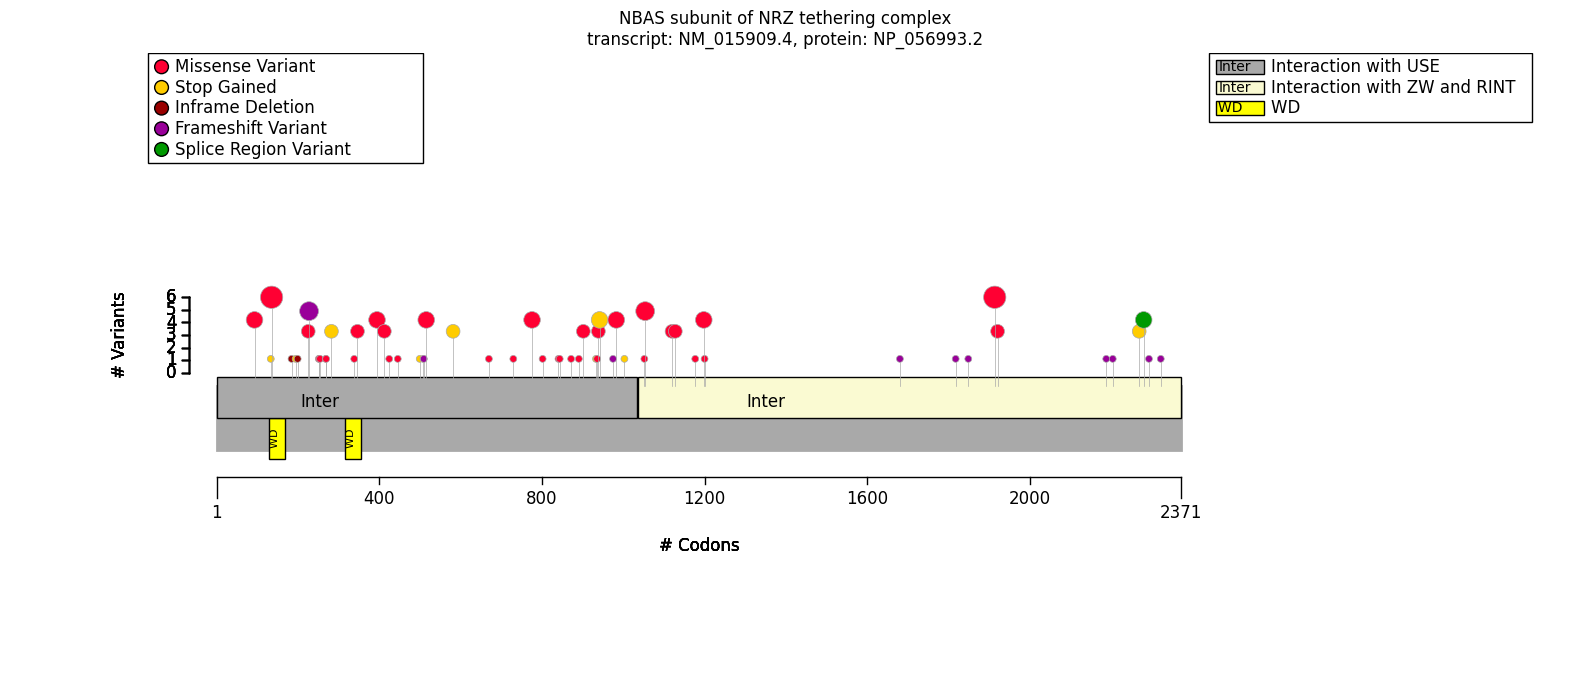

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
from gpsea.model import ProteinMetadata
from gpsea.view import ProteinVisualizable, ProteinVisualizer

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
Interaction with USE1,REGION,1 - 1035,68,p.Ser414Phe; p.Gly340Arg; p.Trp135Ter; p.Lys284Ter; p.Trp583Ter; p.Leu271Pro; p.Ile984Ser; p.Pro937Ala; p.Ile984LeufsTer8; p.Leu202del; p.Ala95Val; p.Val892Phe; p.Ile512ThrfsTer4; p.Pro777His; p.Gly254Asp; p.Arg137Trp; p.Pro348Ser; p.Gly270Ala; p.Trp396Ter; p.Ser976ProfsTer16; p.Cys256Tyr; p.Glu447Lys; p.Arg510Ter; p.His940Pro; p.Thr731Pro; p.Leu903Arg; p.Val253Gly; p.Arg517His; p.Trp934Ter; p.Cys426Trp; p.Ser230GlnfsTer4; p.Arg1004Ter; p.Gln196Ter; p.Phe671Cys; p.Glu803Lys; p.Trp396Arg; p.Trp845Cys; p.Glu943Ter; p.Arg873Trp; p.Val842Phe; p.His227Pro; p.Ile187del; p.Arg517Cys; p.Arg501Ter
WD 1,REPEAT,130 - 169,7,p.Trp135Ter; p.Arg137Trp
WD 2,REPEAT,316 - 355,3,p.Gly340Arg; p.Pro348Ser
Interaction with ZW10 and RINT1,REGION,1036 - 2371,34,p.Ser1178Arg; p.Ser1819LysfsTer16; p.His1053Arg; p.Gln2322HisfsTer18; p.Trp1850GlyfsTer32; p.Ser1129Phe; p.Ile1121Met; p.Gln1201Pro; p.Thr2280=; p.Glu2189Ter; p.Arg1914Gly; p.Arg1914His; p.Met2204IlefsTer3; p.Cys1199Tyr; p.Ala1921Pro; p.Ser1681GlnfsTer37; p.Glu2269Ter; p.Leu2293CysfsTer9; p.Leu1055Pro


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
2_15539327_15539327_G_A,c.409C>T,p.Arg137Trp,7,missense,6
SO:1000029_HGNC:15625_NBAS,SV involving NBAS,p.?,,chromosomal deletion,6
2_15238670_15238670_C_T,c.5741G>A,p.Arg1914His,45,missense,5
2_15394320_15394320_A_G,c.3164T>C,p.Leu1055Pro,28,missense,4
2_15534602_15534602_G_GA,c.686dup,p.Ser230GlnfsTer4,9,frameshift,4
2_15461210_15461210_G_T,c.2330C>A,p.Pro777His,21,missense,3
2_15415656_15415656_C_A,c.2827G>T,p.Glu943Ter,25,stop gained,3
2_15374715_15374715_C_T,c.3596G>A,p.Cys1199Tyr,31,missense,3
2_15554064_15554064_G_A,c.284C>T,p.Ala95Val,4,missense,3
2_15468510_15468510_C_T,c.1749G>A,p.Trp583Ter,17,stop gained,2


In [8]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter( hpo=hpo, annotation_frequency_threshold=0.01)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate


missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


gt_predicate = biallelic_predicate(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                   partitions=((0,),(2,1))
                                   )
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,28
HMF03,Skipping term because of a child term with the same individual counts,14
HMF05,Skipping term because one genotype had zero observations,3
HMF06,Skipping term with less than 7 observations (not powered for 2x2),146
HMF08,Skipping general term,90


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense/missense          \
                                                               Count Percent   
Decreased circulating IgG level [HP:0004315]                    1/12      8%   
Hyposegmentation of neutrophil nuclei [HP:0011447]              3/16     19%   
Hypertelorism [HP:0000316]                                       3/5     60%   
Seizure [HP:0001250]                                             2/4     50%   
Downslanted palpebral fissures [HP:0000494]                      3/4     75%   
...                                                              ...     ...   
Abnormal finger morphology [HP:0001167]                          1/1    100%   
Generalized abnormality of skin [HP:0011354]                     1/1    100%   
Decreased adipose tissue [HP:0040063]                            1/1    100%   
Abnormality of subcutaneous fat tissue [HP:0001...               1/1    100%   
Microvesicular hepatic steatosis [HP:0001414]                    1/2     50%   

Allele group                                       other/other OR missense/other  \
                                                                           Count   
Decreased circulating IgG level [HP:0004315]                               15/23   
Hyposegmentation of neutrophil nuclei [HP:0011447]                         17/31   
Hypertelorism [HP:0000316]                                                  1/13   
Seizure [HP:0001250]                                                        1/15   
Downslanted palpebral fissures [HP:0000494]                                  0/3   
...                                                                          ...   
Abnormal finger morphology [HP:0001167]                                      6/6   
Generalized abnormality of skin [HP:0011354]                                 6/6   
Decreased adipose tissue [HP:0040063]                                        6/6   
Abnormality of subcutaneous fat tissue [HP:0001...                           6/6   
Microvesicular hepatic steatosis [HP:0001414]                                3/5   

Allele group                                                                   \
                                                   Percent Corrected p values   
Decreased circulating IgG level [HP:0004315]           65%           0.127289   
Hyposegmentation of neutrophil nuclei [HP:0011447]     55%           1.000000   
Hypertelorism [HP:0000316]                              8%           1.000000   
Seizure [HP:0001250]                                    7%           1.000000   
Downslanted palpebral fissures [HP:0000494]             0%           1.000000   
...                                                    ...                ...   
Abnormal finger morphology [HP:0001167]               100%           1.000000   
Generalized abnormality of skin [HP:0011354]          100%           1.000000   
Decreased adipose tissue [HP:0040063]                 100%           1.000000   
Abnormality of subcutaneous fat tissue [HP:0001...    100%           1.000000   
Microvesicular hepatic steatosis [HP:0001414]          60%           1.000000   

Allele group                                                  
                                                    p values  
Decreased circulating IgG level [HP:0004315]        0.001611  
Hyposegmentation of neutrophil nuclei [HP:0011447]  0.028638  
Hypertelorism [HP:0000316]                          0.044118  
Seizure [HP:0001250]                                0.097007  
Downslanted palpebral fissures [HP:0000494]         0.142857  
...                                                      ...  
Abnormal finger morphology [HP:0001167]             1.000000  
Generalized abnormality of skin [HP:0011354]        1.000000  
Decreased adipose tissue [HP:0040063]               1.000000  
Abnormality of subcutaneous fat tissue [HP:0001...  1.000000  
Microvesicular hepatic steatosis [HP:0001414]       1.00